In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import nltk
import cv2
import seaborn as sns
import numpy as np
import re 
import random

from operator import itemgetter
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize   

from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition

from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Doc2Vec
from sklearn import cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models.doc2vec import TaggedDocument

from sklearn.metrics import accuracy_score, f1_score

import multiprocessing
cores = multiprocessing.cpu_count()

from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from sklearn import utils
from keras.utils import np_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras import layers
from keras import backend as K

# <font color='red'> 2) Data 

In [4]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [5]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
df[["product_category_tree"]]

,product_category_tree
0,"[""Home Furnishing >> Curtains & Accessories >>..."
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


In [8]:
#df['product_specifications'][0]

In [9]:
df['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [10]:
#Split up the different product categories into separate columns
category_tree = df["product_category_tree"].str.split(">>", expand = True) 

In [11]:
df['product_specifications'].iloc[1]

'{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}'

In [12]:
df['description'].iloc[1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

In [13]:
df = df[['image', 'product_name','description','product_category_tree', 'brand']]

In [14]:
#Replace non-useful characters
for i in category_tree.columns:
    category_tree[i] = category_tree[i].str.replace('[', '')
    category_tree[i] = category_tree[i].str.replace(']', '')
    category_tree[i] = category_tree[i].str.replace('"', '')
    category_tree[i] = category_tree[i].str.replace('"', '')

<ipython-input-14-c1c5145bed99>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  category_tree[i] = category_tree[i].str.replace('[', '')
<ipython-input-14-c1c5145bed99>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  category_tree[i] = category_tree[i].str.replace(']', '')


In [15]:
#Split up the different category levels
for i in category_tree.columns:
    df[f"category_lvl_{i}"] = category_tree[i]

In [16]:
df

,image,product_name,description,product_category_tree,brand,category_lvl_0,category_lvl_1,category_lvl_2,category_lvl_3,category_lvl_4,category_lvl_5,category_lvl_6
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Elegance,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Eurospa,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",SANTOSH ROYAL FASHION,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Jaipur Print,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None
1047,5912e037d12774bb73a2048f35a00009.jpg,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Uberlyfe,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None


In [17]:
df['category_lvl_0'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: category_lvl_0, dtype: int64

In [18]:
df['category_lvl_1'].value_counts()

 Wrist Watches                      149
 Laptop Accessories                  87
 Infant Wear                         84
 Coffee Mugs                         74
 Showpieces                          71
                                   ... 
 Candles & Fragrances                 1
 Consumables & Disposables            1
 JMD Home Furnishing                  1
 TRUE Home Decor & Festive Needs      1
 Beauty Accessories                   1
Name: category_lvl_1, Length: 63, dtype: int64

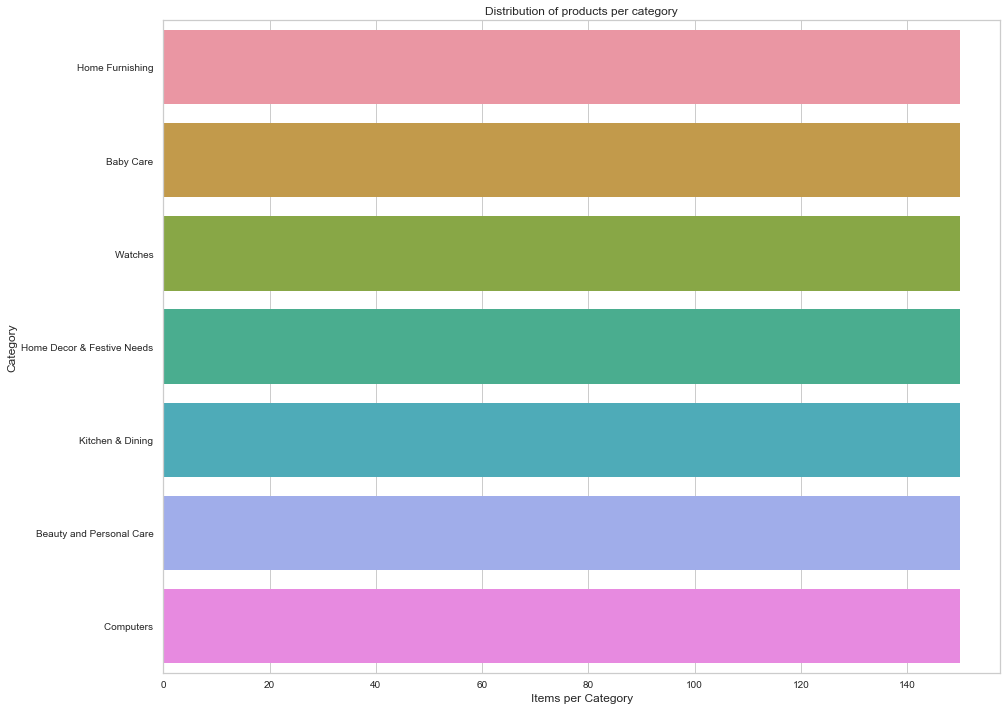

In [19]:
# Plot the frequency of the different categories of products
plt.figure(2, figsize=(15, 12))
plt.title('Distribution of products per category')
sns.countplot(y = df['category_lvl_0'], orient = "h", order = df['category_lvl_0'].value_counts().index)
plt.xlabel('Items per Category', fontsize = 12)
plt.ylabel('Category', fontsize = 12)
plt.yticks(fontsize = 10)
plt.show()

<AxesSubplot:>

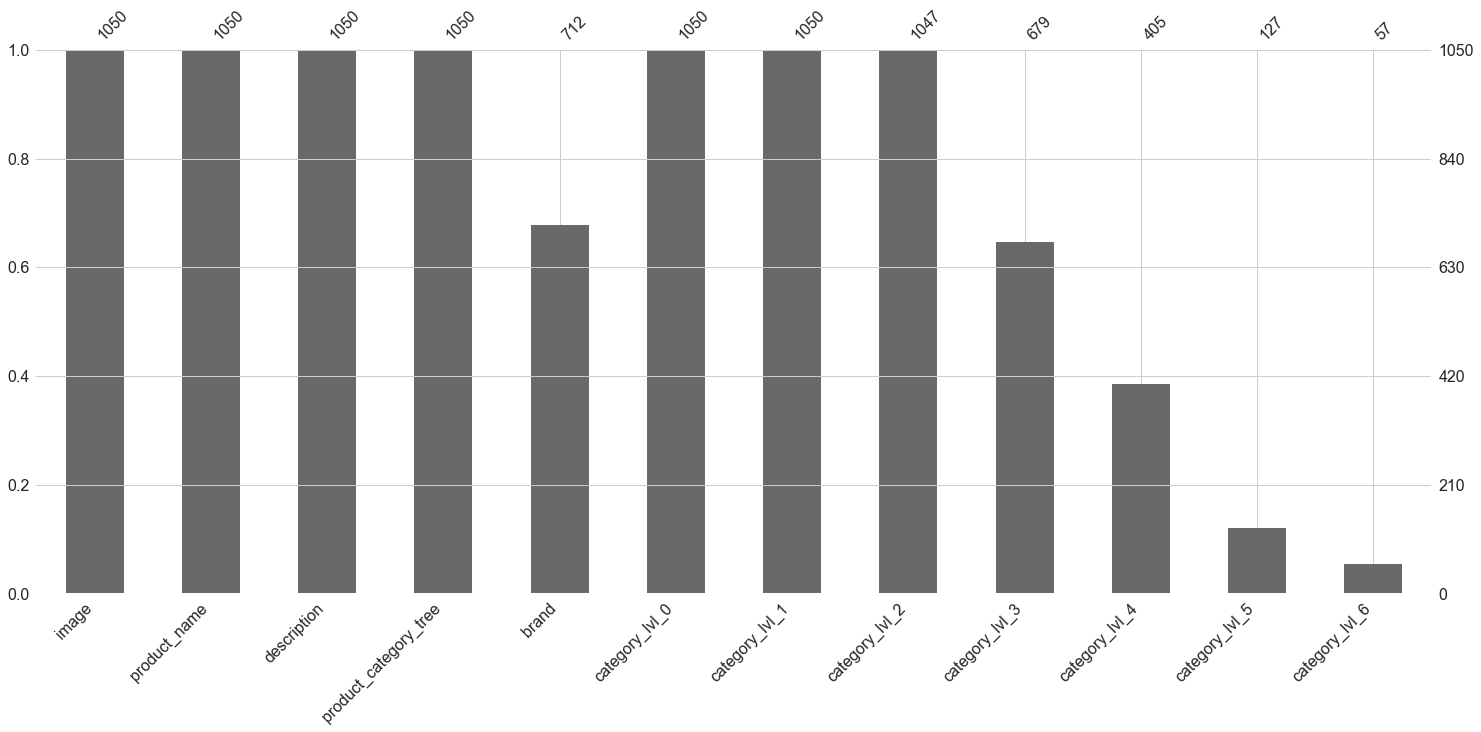

In [20]:
#Check missing data
msno.bar(df)

In [21]:
list(df.columns)

['image',
 'product_name',
 'description',
 'product_category_tree',
 'brand',
 'category_lvl_0',
 'category_lvl_1',
 'category_lvl_2',
 'category_lvl_3',
 'category_lvl_4',
 'category_lvl_5',
 'category_lvl_6']

In [22]:
df=df.drop(['product_category_tree','category_lvl_3',
            'category_lvl_4','category_lvl_5', 'category_lvl_6'], axis=1)

# <font color='red'> 6) filter words in description

In [23]:
df['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [24]:
# imputation of the missing 'brand' field by ''
df['brand'] = df['brand'].fillna('')

In [25]:
# Mixing product name, description and brand into a new feature
df['descriptions'] = df['product_name'] + ' ' + df['description'] + ' ' + df['brand']
df = df.drop(['product_name', 'description', 'brand'], axis=1)

# <font color='red'> Lower case to all columns

In [26]:
df["descriptions"]=df["descriptions"].str.lower()
df["category_lvl_0"]=df["category_lvl_0"].str.lower()
df["category_lvl_1"]=df["category_lvl_1"].str.lower()
df["category_lvl_2"]=df["category_lvl_2"].str.lower()

In [27]:
print (df['descriptions'][0])

elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant 

# split number and text

In [28]:
def Make_Space(text): 
    pattern = '(\d+(\.\d+)?)'
    text = re.sub(pattern,  r' \1 ', text)
    return text

In [29]:
#Replacing in all rows
df['descriptions'] = df['descriptions'].apply(Make_Space)

In [30]:
df['descriptions'][0]

'elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain ( 213  cm in height, pack of  2 ) price: rs.  899  this curtain enhances the look of the interiors.this curtain is made from  100 % high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the

# split number stop words

In [31]:
### , |_|-|!|.|*|?|:

In [32]:
def split_special(text): 
    pattern = "(?<=\w)([!?,.:]_-+)"
    text = re.sub(pattern,  r' \1 ', text)
    return text

In [33]:
#Replacing in all rows
df['descriptions'] = df['descriptions'].apply(split_special)

In [34]:
df['descriptions'][0]

'elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain ( 213  cm in height, pack of  2 ) price: rs.  899  this curtain enhances the look of the interiors.this curtain is made from  100 % high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the

In [35]:
def split_special4(text): 
    pattern = r'[?|$|.|!|_|-|"|/|+]'
    text = re.sub(pattern,  r'', text)
    return text

In [36]:
#Replacing in all rows
df['descriptions'] = df['descriptions'].apply(split_special4)

In [37]:
df['descriptions'][0]

'elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain ( 213  cm in height, pack of  2 ) price: rs  899  this curtain enhances the look of the interiorsthis curtain is made from  100 % high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant- wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints bring home the elegant 

In [38]:
#import re
#the_str = "4x5x6"
#print re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", the_str).strip() // \1 refers to first variable in ()

In [39]:

#strs = "how much for the maple syrup? $20.99? That's ricidulous!!!"
#print (strs)
#nstr = re.sub(r'[?|$|.|!]',r'',strs)
#print (nstr)
#nestr = re.sub(r'[^a-zA-Z0-9 ]',r'',nstr)
#print (nestr)

In [40]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\AJ
[nltk_data]     ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\AJ
[nltk_data]     ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\AJ
[nltk_data]     ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#  Tokenisation

In [41]:

#  Tokenisation
df['tokenize_text'] = df['descriptions'].apply(word_tokenize)

In [42]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', ',', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '(', '213', 'cm', 'in', 'height', ',', 'pack', 'of', '2', ')', 'price', ':', 'rs', '899', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiorsthis', 'curtain', 'is', 'made', 'from', '100', '%', 'high', 'quality', 'polyester', 'fabricit', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ringit', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'lovingthis', 'curtain', 'is', 'ant-', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparancegive', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'these', 'contemporary', 'eyelet', 'and

# remove stop words

In [43]:
def remove_stopwords(text):
    full_stopwords = stopwords.words('english')
    text = [word for word in text if word not in full_stopwords]
    return text

In [44]:
df['tokenize_text'] = df['tokenize_text'].apply(remove_stopwords)

In [45]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', ',', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '(', '213', 'cm', 'height', ',', 'pack', '2', ')', 'price', ':', 'rs', '899', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', '100', '%', 'high', 'quality', 'polyester', 'fabricit', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'makes', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw'

# remove Numbers

In [46]:
for i in range(len(df['tokenize_text'])):
    df['tokenize_text'][i] = [word for word in df['tokenize_text'][i] if not word.isdigit()]

In [47]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', ',', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '(', 'cm', 'height', ',', 'pack', ')', 'price', ':', 'rs', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', '%', 'high', 'quality', 'polyester', 'fabricit', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'makes', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', ',',

In [48]:
for i in range(len(df['tokenize_text'])):
    df['tokenize_text'][i] = [word for word in df['tokenize_text'][i] if len(word)>=3]

In [49]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabricit', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'makes', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'bea

In [50]:
##### the word product is still active even after i have removed it 

In [51]:
extra = [',','',',','-', '&', '.', 'cm','!',"free","delivery",
                     "shipping","flipkart.com","flipkart.com.","rs.","buy",
                     "cash","delivery!","price:","guarantee.","guarantee.",
                    "day","flipkart","com","warranty","sale","warranty",
                     "detail","specification","product","flipkartcom"]

In [52]:
extra2=["replacement","sale","general","type","specification","online","feature"
        ,"'s","guarantee","price","product","r"]

# remove unwanted words

In [53]:
def remove_extra(text):
    full_stopwords = stopwords.words('english')
    text = [word for word in text if word not in extra]
    return text

In [54]:
df['tokenize_text'] = df['tokenize_text'].apply(remove_extra)

In [55]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabricit', 'features', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'makes', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'designs', 'surreal', 'attention', 'sure', 'steal', 'hearts', 'contemporary', 'eyelet', 'valance', 'curtains', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'rays', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moments', 'joyous', 'bea

# Lemmanize words

In [56]:
# Create function to lemmatize
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return text

In [57]:
df['tokenize_text'] = df['tokenize_text'].apply(lemmatize)

In [58]:
print (df['tokenize_text'][0])

['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabricit', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'make', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'g

In [59]:
######this is not working correctly

In [60]:
# Create a Unique Word collection=Spacy
# Aggregate all the descriptions together
corpus = df['tokenize_text'].str#.cat(sep=' ').lower()

# Get the list of words
list_words = corpus.split()
print("Number of words: {}".format(len(list_words)))
print("Number of unique words: {}".format(len(set(list_words))))

Number of words: 1050
Number of unique words: 1050


In [61]:
df['tokenize_text'][0]

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interiorsthis',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'make',
 'room',
 'environment',
 'romantic',
 'lovingthis',
 'curtain',
 'ant-',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparancegive',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'wor

In [62]:
def recuperer_ensemble_mots(descriptions_tokenisees):
    """
    Retourne la liste complète des mots de chacune des descriptions tokenisees.
    
    
    Paramètre :
        - descriptions_tokenisees : Series
    """
    
    liste_totalite_mots = []
    for index, description_tokenisee in descriptions_tokenisees.items():
        for mot in description_tokenisee:
            liste_totalite_mots.append(mot)
            
    return liste_totalite_mots

In [63]:
def calculer_frequences_apparitions_mots(liste_mots):
    """
    Calcule la fréquence d'apparition de chaque mot présent dans liste_mots et retourne 
    un DataFrame contenant ces fréquences.
    
    Paramètre : 
        - liste_mots : List
    """
    
    frequences_apparitions_mots = nltk.FreqDist(liste_mots)
    df_freq = pd.DataFrame.from_dict(frequences_apparitions_mots, orient='index', columns=['nb_apparitions'])
    df_freq.sort_values(by="nb_apparitions", ascending=False, inplace=True)
    return df_freq

In [64]:
liste_mots = recuperer_ensemble_mots(df['tokenize_text'])
frequences_apparition_mots = calculer_frequences_apparitions_mots(liste_mots)

In [65]:
#Top 50 most used words in all descriptions before words were removed

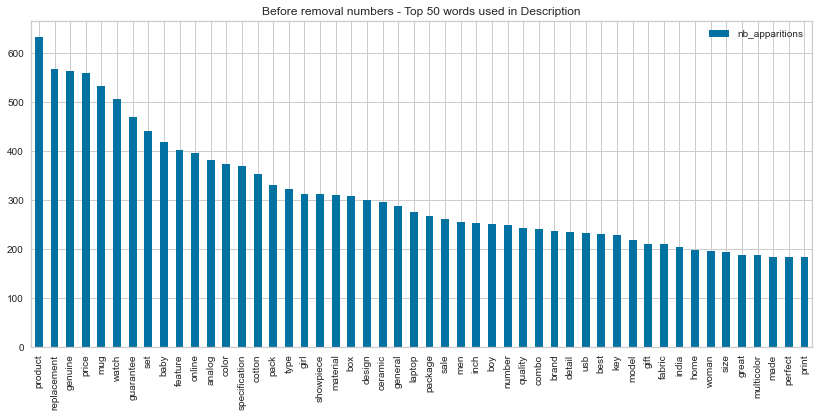

In [66]:
# Display of the 50 most used words in all descriptions
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

titre = 'Before removal numbers - Top 50 words used in Description'
frequences_apparition_mots[:50].plot(kind='bar', 
                                     title=titre);

In [67]:
frequences_apparition_mots.head(30)

,nb_apparitions
product,634
replacement,568
genuine,564
price,559
mug,534
watch,506
guarantee,471
set,442
baby,420
feature,403


In [68]:
extra2=["replacement","sale","general","type","specification","online","feature"
        ,"'s","guarantee","price","product","r","genuine","best","number","inch"
        ,"quality","color","detail","set","made"
       ,"perfect","''","discount","showpiece","gift","pack","design","dimension","ideal","black","shape","india","men","woman"
        ,"multicolor","width","content","maximum"]

In [69]:
extra3= ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

In [70]:
extra4=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# remove unwanted words

In [71]:
def remove_extra2(text):
    full_stopwords = stopwords.words('english')
    text = [word for word in text if word not in extra2]
    return text

In [72]:
def remove_extra3(text):
    full_stopwords = stopwords.words('english')
    text = [word for word in text if word not in extra3]
    return text

In [73]:
def remove_extra4(text):
    full_stopwords = stopwords.words('english')
    text = [word for word in text if word not in extra4]
    return text

In [74]:
df['tokenize_text'] = df['tokenize_text'].apply(remove_extra2)
df['tokenize_text'] = df['tokenize_text'].apply(remove_extra3)
df['tokenize_text'] = df['tokenize_text'].apply(remove_extra4)
df['tokenize_text'] = df['tokenize_text'].apply(remove_extra)

In [75]:
print(df['tokenize_text'][0])

['elegance', 'polyester', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'elegance', 'polyester', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'curtain', 'enhances', 'interiorsthis', 'curtain', 'high', 'polyester', 'fabricit', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant-', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'surreal', 'attention', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'first', 'thing', 'morning', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'softly', 'filter', 'light', 'room', 'sunlight', 'elegance', 'polyester', 'abstract', 'eyelet', 'door', '

In [76]:
liste_mots = recuperer_ensemble_mots(df['tokenize_text'])
frequences_apparition_mots = calculer_frequences_apparitions_mots(liste_mots)

In [77]:
frequences_apparition_mots.head(50)

,nb_apparitions
watch,506
baby,420
analog,382
cotton,353
girl,313
material,310
box,309
ceramic,296
laptop,276
package,269


In [78]:
#Top 50 most used words in all descriptions After words were removed

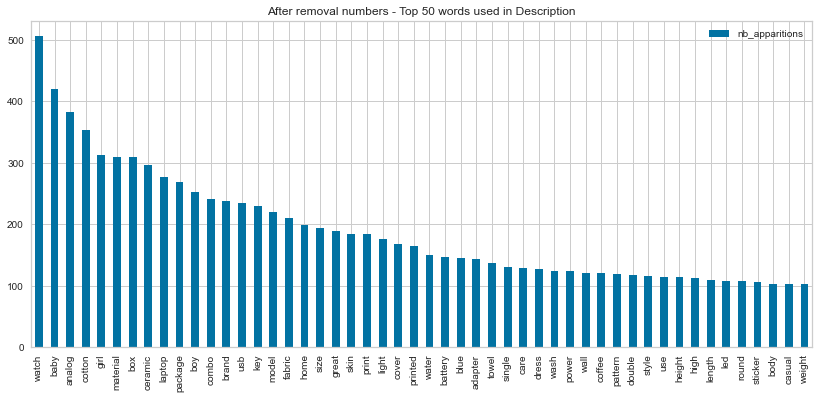

In [79]:
# Display of the 50 most used words in all descriptions
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

titre = 'After removal numbers - Top 50 words used in Description'
frequences_apparition_mots[:50].plot(kind='bar', 
                                     title=titre);

In [80]:
for index, row in df.iterrows():
    df.at[index, 'tokenize_text'] = ' '.join(row['tokenize_text'])

df

,image,category_lvl_0,category_lvl_1,category_lvl_2,descriptions,tokenize_text
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,curtains & accessories,curtains,elegance polyester multicolor abstract eyelet ...,elegance polyester abstract eyelet door curtai...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,baby bath & skin,baby bath towels,sathiyas cotton bath towel specifications of s...,sathiyas cotton bath towel sathiyas cotton bat...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,baby bath & skin,baby bath towels,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel key eurospa co...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,bed linen,bedsheets,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,bed linen,bedsheets,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,baby & kids gifts,stickers,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,baby & kids gifts,stickers,wallmantra large vinyl sticker sticker wallman...,wallmantra large vinyl sticker sticker wallman...
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,baby & kids gifts,stickers,uberlyfe extra large pigmented polyvinyl films...,uberlyfe extra large pigmented polyvinyl film ...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,baby & kids gifts,stickers,wallmantra medium vinyl sticker sticker buy wa...,wallmantra medium vinyl sticker sticker wallma...


In [81]:
#build technics based on 
#bag of word
#doc to vec
#IDF


In [82]:
# creating resultds dataframe
results = pd.DataFrame(columns=['Model', 'Category', 'Train acc', 'Test acc'])#, 'Total acc'
results

,Model,Category,Train acc,Test acc


In [83]:
# using bag of words 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#X = cv.fit_transform(df.tokenize_text)

In [84]:
df.tokenize_text

0       elegance polyester abstract eyelet door curtai...
1       sathiyas cotton bath towel sathiyas cotton bat...
2       eurospa cotton terry face towel key eurospa co...
3       santosh royal fashion cotton printed king size...
4       jaipur print cotton floral king sized double b...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker wallman...
1047    uberlyfe extra large pigmented polyvinyl film ...
1048    wallmantra medium vinyl sticker sticker wallma...
1049    uberlyfe large vinyl sticker uberlyfe large vi...
Name: tokenize_text, Length: 1050, dtype: object

In [85]:
X = CountVectorizer().fit_transform(df['tokenize_text'])

In [86]:
from sklearn.preprocessing import LabelEncoder
# convertig categories into numbers
y = df[['category_lvl_0' ,'category_lvl_1', 'category_lvl_2']]
y = y.apply(LabelEncoder().fit_transform)
y

,category_lvl_0,category_lvl_1,category_lvl_2
0,4,19,65
1,0,1,9
2,0,1,9
3,4,8,28
4,4,8,28
...,...,...,...
1045,0,0,208
1046,0,0,208
1047,0,0,208
1048,0,0,208


In [87]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# model perfomance on train test and total for bag of words on category 1

X_train, X_test, y_train, y_test = train_test_split(X, y.category_lvl_0, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[0, 'Model'] = 'Bag of words'
results.at[0, 'Category'] = 1
results.at[0, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[0, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X, y.category_lvl_0)
yhat = clf.predict(X)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_0, yhat))
#results.at[0, 'Total acc'] = accuracy_score(y.category_lvl_0, yhat)*100

Accuracy on train data:  0.9863945578231292
Accuracy on test data:  0.9238095238095239


In [88]:
# model perfomance on train test and total for bag of words on category 2
X_train, X_test, y_train, y_test = train_test_split(X, y.category_lvl_1, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[1, 'Model'] = 'Bag of words'
results.at[1, 'Category'] = 2
results.at[1, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[1, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X, y.category_lvl_1)
yhat = clf.predict(X)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_1, yhat))
#results.at[1, 'Total acc'] = accuracy_score(y.category_lvl_1, yhat)*100

Accuracy on train data:  0.9904761904761905
Accuracy on test data:  0.8158730158730159


In [89]:
# model perfomance on train test and total for bag of words on category 3

X_train, X_test, y_train, y_test = train_test_split(X, y.category_lvl_2, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[2, 'Model'] = 'Bag of words'
results.at[2, 'Category'] = 3
results.at[2, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[2, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X, y.category_lvl_2)
yhat = clf.predict(X)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_2, yhat))
#results.at[2, 'Total acc'] = accuracy_score(y.category_lvl_2, yhat)*100

Accuracy on train data:  0.926530612244898
Accuracy on test data:  0.6761904761904762


In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
# using tfidf technique
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(df.descriptions)
print(X_tfidf.shape)

(1050, 6078)


In [91]:
# model perfomance on train test and total for bag of words on category 1
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_0, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[3, 'Model'] = 'TF-IDF'
results.at[3, 'Category'] = 1
results.at[3, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[3, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_0)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_0, yhat))
#results.at[3, 'Total acc'] = accuracy_score(y.category_lvl_0, yhat)*100

Accuracy on train data:  0.9863945578231292
Accuracy on test data:  0.9015873015873016


In [92]:
# model perfomance on train test and total for bag of words on category 2
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_1, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[4, 'Model'] = 'TF-IDF'
results.at[4, 'Category'] = 2
results.at[4, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[4, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_1)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_1, yhat))
#results.at[4, 'Total acc'] = accuracy_score(y.category_lvl_1, yhat)*100

Accuracy on train data:  0.6108843537414966
Accuracy on test data:  0.5301587301587302


In [93]:
# model perfomance on train test and total for bag of words on category 3
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_2, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[5, 'Model'] = 'TF-IDF'
results.at[5, 'Category'] = 3
results.at[5, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[5, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_2)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_2, yhat))
#results.at[5, 'Total acc'] = accuracy_score(y.category_lvl_2, yhat)*100

Accuracy on train data:  0.5034013605442177
Accuracy on test data:  0.3746031746031746


In [94]:
tempdf = df

In [95]:
ps = PorterStemmer()

for index, row in tempdf.iterrows():
    lower = row['descriptions'].lower()
    tokens = lower.split(' ')

    wordsFiltered = []
    for w in tokens:
        wordsFiltered.append(ps.stem(w))
    
    description = ' '.join(wordsFiltered)
    tempdf.at[index,'descriptions']=description

In [96]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(tempdf['tokenize_text'])

In [97]:
y = tempdf[['category_lvl_0' ,'category_lvl_1', 'category_lvl_2']]
y = y.apply(LabelEncoder().fit_transform)

In [98]:
# model perfomance on train test and total for bag of words on category 1
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_0, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[6, 'Model'] = 'TF-IDF PS'
results.at[6, 'Category'] = 1
results.at[6, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[6, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_0)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_0, yhat))
#results.at[6, 'Total acc'] = accuracy_score(y.category_lvl_0, yhat)*100


Accuracy on train data:  0.9836734693877551
Accuracy on test data:  0.8857142857142857


In [99]:
# model perfomance on train test and total for bag of words on category 2
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_1, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[7, 'Model'] = 'TF-IDF PS'
results.at[7, 'Category'] = 2
results.at[7, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[7, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_1)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_1, yhat))
#results.at[7, 'Total acc'] = accuracy_score(y.category_lvl_1, yhat)*100

Accuracy on train data:  0.6925170068027211
Accuracy on test data:  0.6158730158730159


In [100]:
# model perfomance on train test and total for bag of words on category 3
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_2, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[8, 'Model'] = 'TF-IDF PS'
results.at[8, 'Category'] = 3
results.at[8, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[8, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_2)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_2, yhat))
#results.at[8, 'Total acc'] = accuracy_score(y.category_lvl_2, yhat)*100

Accuracy on train data:  0.5564625850340136
Accuracy on test data:  0.4444444444444444


In [101]:
tempdf = df

In [102]:
ps = LancasterStemmer()

for index, row in tempdf.iterrows():
    lower = row['descriptions'].lower()
    tokens = lower.split(' ')

    wordsFiltered = []
    for w in tokens:
        wordsFiltered.append(ps.stem(w))
    
    description = ' '.join(wordsFiltered)
    tempdf.at[index,'descriptions']=description

In [103]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(tempdf['tokenize_text'])

In [104]:
y = tempdf[['category_lvl_0' ,'category_lvl_1', 'category_lvl_2']]
y = y.apply(LabelEncoder().fit_transform)

In [105]:
# model perfomance on train test and total for bag of words on category 3
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_0, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[9, 'Model'] = 'TF-IDF LS'
results.at[9, 'Category'] = 1
results.at[9, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[9, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_0)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_0, yhat))
#results.at[9, 'Total acc'] = accuracy_score(y.category_lvl_0, yhat)*100

Accuracy on train data:  0.9877551020408163
Accuracy on test data:  0.9396825396825397


In [106]:
# model perfomance on train test and total for bag of words on category 3
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_1, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[10, 'Model'] = 'TF-IDF LS'
results.at[10, 'Category'] = 2
results.at[10, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[10, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_1)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_1, yhat))
#results.at[10, 'Total acc'] = accuracy_score(y.category_lvl_1, yhat)*100

Accuracy on train data:  0.6421768707482993
Accuracy on test data:  0.526984126984127


In [107]:
# model perfomance on train test and total for bag of words on category 3
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y.category_lvl_2, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
yhat = clf.predict(X_train)
print("Accuracy on train data: ",accuracy_score(y_train, yhat))
results.at[11, 'Model'] = 'TF-IDF LS'
results.at[11, 'Category'] = 3
results.at[11, 'Train acc'] = accuracy_score(y_train, yhat)*100
yhat = clf.predict(X_test)
print("Accuracy on test data: ",accuracy_score(y_test, yhat))
results.at[11, 'Test acc'] = accuracy_score(y_test, yhat)*100
clf = MultinomialNB()
clf.fit(X_tfidf, y.category_lvl_2)
yhat = clf.predict(X_tfidf)
#print("Accuracy on total data: ",accuracy_score(y.category_lvl_2, yhat))
#results.at[11, 'Total acc'] = accuracy_score(y.category_lvl_2, yhat)*100

Accuracy on train data:  0.5795918367346938
Accuracy on test data:  0.4380952380952381


In [108]:
tempdf = df

In [109]:
train, test = train_test_split(tempdf, test_size=0.3, random_state=42)

In [110]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [111]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [112]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_0]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_0]), axis=1)

In [113]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 735/735 [00:00<?, ?it/s]


In [114]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 735/735 [00:00<00:00, 713779.45it/s]

Wall time: 1.08 s


In [115]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
results.at[12, 'Model'] = 'Doc2Vec'
results.at[12, 'Category'] = '1'
results.at[12, 'Test acc'] = accuracy_score(y_test, y_pred)*100

print('Train accuracy %s' % accuracy_score(y_train, y_pred_train))
results.at[12, 'Train acc'] = accuracy_score(y_train, y_pred_train)*100

Testing accuracy 0.5777777777777777
Train accuracy 0.710204081632653


C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_1]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_1]), axis=1)

In [117]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 735/735 [00:00<?, ?it/s]


In [118]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 735/735 [00:00<?, ?it/s]

Wall time: 1.08 s


In [119]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
results.at[13, 'Model'] = 'Doc2Vec'
results.at[13, 'Category'] = '2'
results.at[13, 'Test acc'] = accuracy_score(y_test, y_pred)*100

print('Train accuracy %s' % accuracy_score(y_train, y_pred_train))
results.at[13, 'Train acc'] = accuracy_score(y_train, y_pred_train)*100

Testing accuracy 0.4857142857142857
Train accuracy 0.5918367346938775


C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_1]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tokenize_text']), tags=[r.category_lvl_1]), axis=1)

In [121]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 735/735 [00:00<00:00, 736282.17it/s]


In [122]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 735/735 [00:00<00:00, 737338.78it/s]

Wall time: 1.09 s


In [123]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
results.at[14, 'Model'] = 'Doc2Vec'
results.at[14, 'Category'] = '3'
results.at[14, 'Test acc'] = accuracy_score(y_test, y_pred)*100

print('Train accuracy %s' % accuracy_score(y_train, y_pred_train))
results.at[14, 'Train acc'] = accuracy_score(y_train, y_pred_train)*100

Testing accuracy 0.6317460317460317
Train accuracy 0.7891156462585034


C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
results

,Model,Category,Train acc,Test acc
0,Bag of words,1,98.639456,92.380952
1,Bag of words,2,99.047619,81.587302
2,Bag of words,3,92.653061,67.619048
3,TF-IDF,1,98.639456,90.15873
4,TF-IDF,2,61.088435,53.015873
5,TF-IDF,3,50.340136,37.460317
6,TF-IDF PS,1,98.367347,88.571429
7,TF-IDF PS,2,69.251701,61.587302
8,TF-IDF PS,3,55.646259,44.444444
9,TF-IDF LS,1,98.77551,93.968254


In [125]:
results=results.fillna(0)

In [126]:
results.set_index('Model', inplace=True)

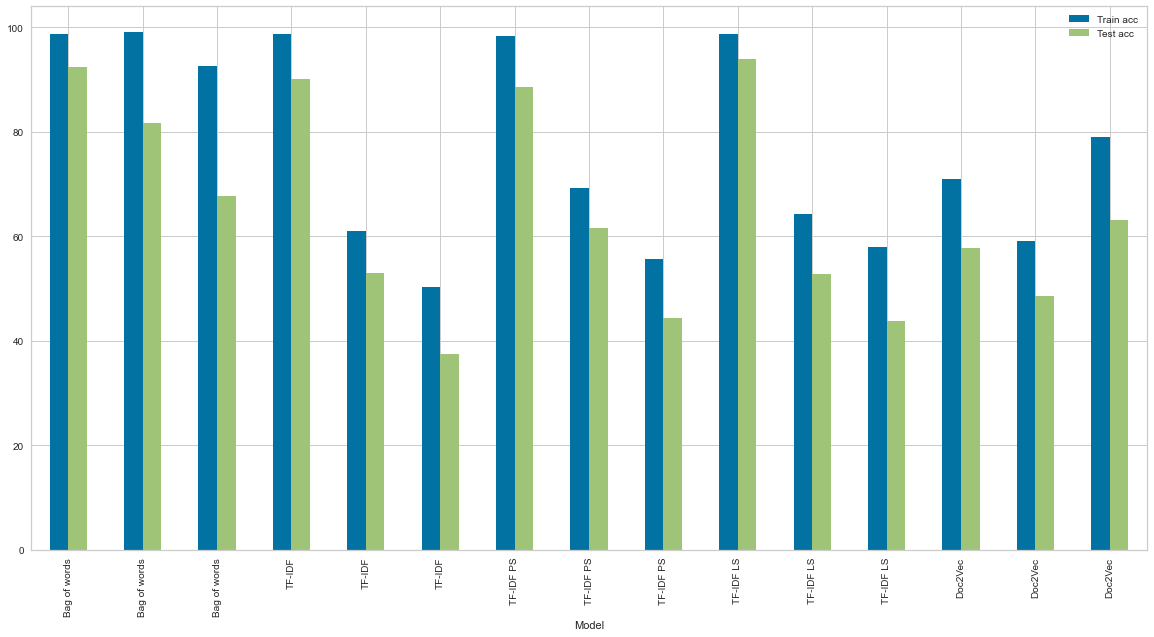

In [127]:
results.plot(kind="bar", figsize=(20, 10))
plt.show()

In [128]:
df_ = df.copy()

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
# using tfidf technique
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(df_.tokenize_text)
print(X_tfidf.shape)

(1050, 4439)


In [130]:
feature_names = tfidf_vect.get_feature_names()
dense = X_tfidf.todense()
denselist = dense.tolist()
df_w_features = pd.DataFrame(denselist, columns=feature_names)

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [131]:
final_tf_df = pd.merge(df_, df_w_features, left_index= True, right_index = True)

In [132]:
final_tf_df

,image_x,category_lvl_0,category_lvl_1,category_lvl_2,descriptions,tokenize_text,aaa,aapno,aari,aarika,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,curtains & accessories,curtains,eleg polyest multicol abstract eyelet door cur...,elegance polyester abstract eyelet door curtai...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,baby bath & skin,baby bath towels,sathiy cotton bath towel spec of sathiy cotton...,sathiyas cotton bath towel sathiyas cotton bat...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,baby bath & skin,baby bath towels,eurosp cotton terr fac towel set key feat of e...,eurospa cotton terry face towel key eurospa co...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,bed linen,bedsheets,santosh roy fash cotton print king siz doubl b...,santosh royal fashion cotton printed king size...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,bed linen,bedsheets,jaip print cotton flor king siz doubl bedsheet...,jaipur print cotton floral king sized double b...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,baby & kids gifts,stickers,or empow extr larg self adh stick or empow ext...,oren empower extra large self adhesive sticker...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,baby & kids gifts,stickers,wallmantr larg vinyl stick stick wallmantr lar...,wallmantra large vinyl sticker sticker wallman...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,baby & kids gifts,stickers,uberlyf extr larg pig polyvinyl film (imported...,uberlyfe extra large pigmented polyvinyl film ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,baby & kids gifts,stickers,wallmantr med vinyl stick stick buy wallmantr ...,wallmantra medium vinyl sticker sticker wallma...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
X_tf = final_tf_df.drop(['image_x','category_lvl_0','category_lvl_1','category_lvl_2','descriptions','tokenize_text'], axis=1)

In [146]:
X_tf

,aaa,aapno,aari,aarika,ability,abklgrngrngrn,abklplplpnk,abklplpnkpnk,abode,abrasion,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [148]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [149]:
pca= PCA(0.95) # I want 95% 
X_pca=pca.fit_transform(X_tf)
X_pca.shape

(1050, 662)

In [150]:
principalComponents = pca.transform(X_tf)
principal_df = pd.DataFrame(data = principalComponents)
             #, columns = ['principal component 1', 'principal component 2','principal component 3'])#,'principal component 4'
                         #,'principal component 5','principal component 6'])

principal_df

,0,1,2,3,4,5,6,7,8,9,...,652,653,654,655,656,657,658,659,660,661
0,-0.080316,-0.025879,-0.058035,0.090134,-0.105494,0.090600,-0.121721,-0.016362,0.010527,0.532284,...,-0.034696,-0.020183,-0.011252,0.015706,-0.004826,0.022669,0.010004,-0.002981,-0.023955,0.022252
1,-0.084198,-0.075398,0.091589,-0.010228,-0.075825,-0.049044,-0.039417,-0.067370,0.579495,-0.136548,...,-0.074001,0.075337,0.039330,-0.053559,-0.023536,0.012696,-0.029150,0.067223,0.066839,-0.031365
2,-0.084711,-0.057316,0.069375,-0.024383,-0.054755,-0.052931,-0.023053,-0.057924,0.491587,-0.119528,...,-0.029850,-0.006642,-0.027273,0.063480,-0.047477,0.027903,-0.031347,0.012027,0.034312,-0.005194
3,-0.072988,-0.061174,0.046629,0.028326,-0.077074,0.092215,-0.002396,-0.023196,0.114473,-0.020081,...,-0.023903,0.064493,0.033189,-0.025603,-0.008330,0.057031,0.029893,-0.003445,-0.006184,0.005617
4,-0.091998,-0.070037,0.027124,0.013884,-0.080963,0.111706,-0.002676,-0.045209,0.134863,-0.009834,...,0.014883,-0.002578,-0.010119,-0.007279,-0.042892,-0.031685,0.006344,0.026009,0.017256,0.008121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.056813,-0.023399,-0.060167,0.011850,-0.039363,-0.029658,-0.008713,0.020549,0.006174,0.026493,...,-0.022612,-0.034327,0.001780,0.044430,-0.043708,0.006225,-0.033005,0.016590,-0.016965,0.011938
1046,-0.072636,0.014295,-0.056893,0.014923,-0.023161,-0.016161,-0.003215,0.010155,0.015368,0.039753,...,0.065771,0.064621,0.023236,-0.090167,0.050034,0.009046,0.024668,0.040527,-0.015782,-0.068999
1047,-0.045330,-0.021099,-0.044434,0.003371,-0.028566,-0.036147,-0.006014,0.009220,0.001426,0.008623,...,-0.035130,-0.003448,-0.059349,-0.070294,-0.046623,0.071335,0.088804,-0.000441,0.059417,0.036877
1048,-0.055187,-0.026671,-0.063701,0.000527,-0.042495,-0.057810,-0.008386,0.008011,0.009382,0.022676,...,-0.016255,-0.014179,-0.003145,0.022083,-0.017447,-0.006905,-0.010673,0.001838,0.002264,0.012173


In [151]:
j = 1
res = []
for i in pca.explained_variance_:
    res.append((i/ pca.explained_variance_.sum())*100)
    print('principal component ',j,' explained variance =>',(i/ pca.explained_variance_.sum())*100)
    j+=1

principal component  1  explained variance => 2.949470973087296
principal component  2  explained variance => 1.9818351864593426
principal component  3  explained variance => 1.591471369379165
principal component  4  explained variance => 1.3108019896351721
principal component  5  explained variance => 1.2181592599969575
principal component  6  explained variance => 1.0640334649972205
principal component  7  explained variance => 0.9941939098932592
principal component  8  explained variance => 0.986198571555502
principal component  9  explained variance => 0.968487420154333
principal component  10  explained variance => 0.9238625971844612
principal component  11  explained variance => 0.9068022157014197
principal component  12  explained variance => 0.8159144064737519
principal component  13  explained variance => 0.7611059407417807
principal component  14  explained variance => 0.7274952520183808
principal component  15  explained variance => 0.7187416596853424
principal component  16

principal component  567  explained variance => 0.0568358339710208
principal component  568  explained variance => 0.056710044778833874
principal component  569  explained variance => 0.056665670296731294
principal component  570  explained variance => 0.056385518448623814
principal component  571  explained variance => 0.056248663764558844
principal component  572  explained variance => 0.055957369868338304
principal component  573  explained variance => 0.0558324336741418
principal component  574  explained variance => 0.05561450639918078
principal component  575  explained variance => 0.05554156441700146
principal component  576  explained variance => 0.05545792036091631
principal component  577  explained variance => 0.0552441548257694
principal component  578  explained variance => 0.05510054339483077
principal component  579  explained variance => 0.05506787162611033
principal component  580  explained variance => 0.054829339768514194
principal component  581  explained variance 

In [152]:
res = pd.DataFrame(res, columns=['Variant'])

In [153]:
res

,Variant
0,2.949471
1,1.981835
2,1.591471
3,1.310802
4,1.218159
...,...
657,0.042200
658,0.042126
659,0.041848
660,0.041540


<Figure size 1440x720 with 0 Axes>

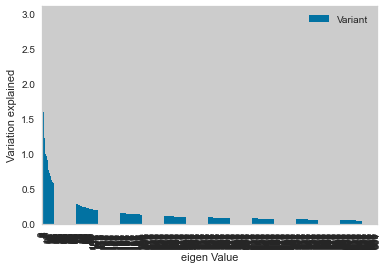

In [154]:
plt.figure(figsize=(20,10))
res.plot.bar()
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

# PCA for TF values

In [155]:
colors = ['#E91E63', '#1976D2','#FF9800','#00CC00','#87CEEB','#AF7AC5','#696969']

In [156]:
pca = decomposition.PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tf)
var_cum = pca.explained_variance_ratio_.cumsum().max()
print('Number of dimensions:',2)
print('Cumulative explained variances:', round(var_cum,2))

Number of dimensions: 2
Cumulative explained variances: 0.05


In [157]:
pca_df = pd.DataFrame(X_pca,columns=['pca-one', 'pca-two'])
pca_df['category_lvl_0'] = final_tf_df['category_lvl_0']

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

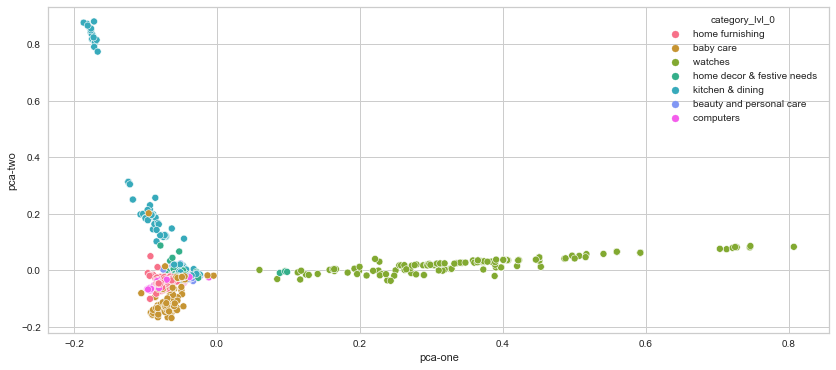

In [158]:
fig = plt.figure(figsize=(14, 6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category_lvl_0",
    #palette=sns.color_palette("Set2"),
    data=pca_df[['pca-one', 'pca-two','category_lvl_0']],
    #legend="full",
    alpha=1
)

# SVD for TF values

In [159]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_trSVD = svd.fit_transform(X_tf)
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Number of dimensions:',2)
print('Cumulative explained variances:', round(var_cum,2))

Number of dimensions: 2
Cumulative explained variances: 0.04


In [160]:
svd_df = pd.DataFrame(X_trSVD,columns=['svd-one', 'svd-two'])
svd_df['category_lvl_0'] = final_tf_df['category_lvl_0']

<AxesSubplot:xlabel='svd-one', ylabel='svd-two'>

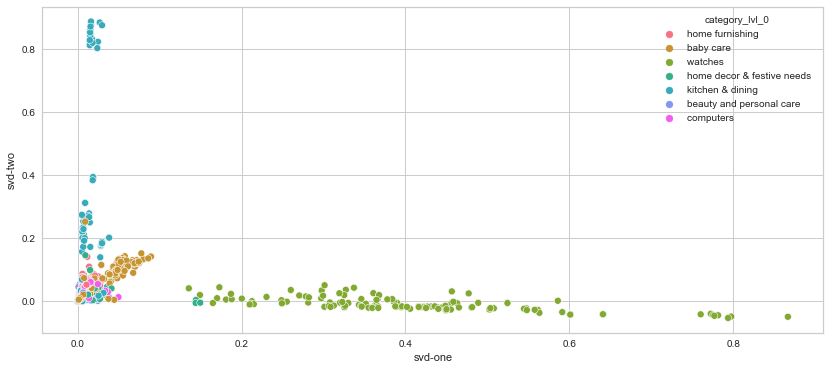

In [161]:
fig = plt.figure(figsize=(14, 6))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="category_lvl_0",
    #palette=sns.color_palette("Set2"),
    data=svd_df[['svd-one', 'svd-two','category_lvl_0']],
    #legend="full",
    alpha=1
)

# Tnse for TF values


In [162]:
# faire des test de perplexity de 3 a 128
#doing tnse 

tsne = TSNE(n_components=2, verbose=1, perplexity=128, n_iter=300)
tsne_results = tsne.fit_transform(X_trSVD)

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 385 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.000s...
[t-SNE] Computed neighbors for 1050 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.004392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.964333
[t-SNE] KL divergence after 300 iterations: 0.150843


In [163]:
tnse_df = pd.DataFrame(tsne_results,columns=['tsne-2d-one', 'tsne-2d-two'])
tnse_df['category_lvl_0'] = final_tf_df['category_lvl_0']

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

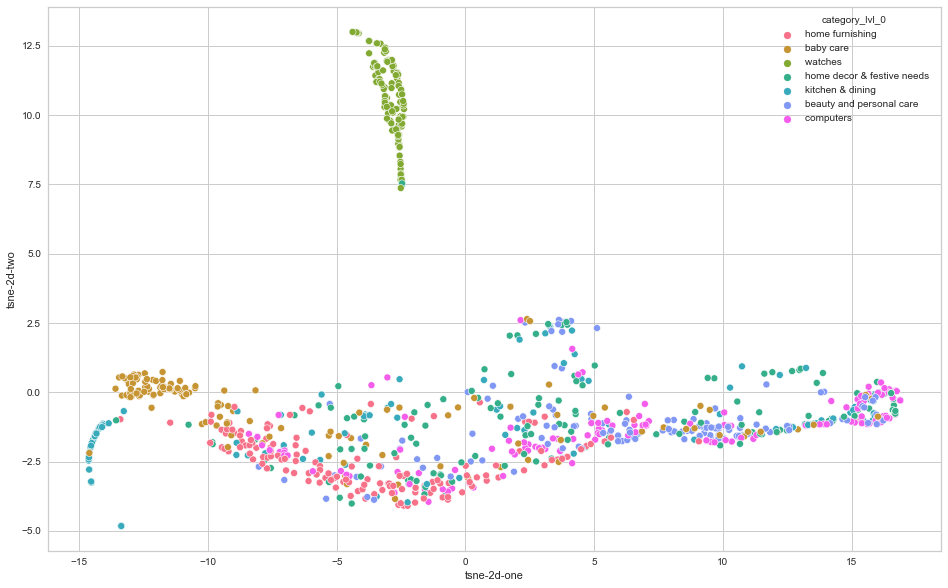

In [149]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tnse_df[['tsne-2d-one', 'tsne-2d-two','category_lvl_0']],#"category_lvl_0"
    legend="full",
    hue="category_lvl_0",
    alpha=1
)

# LDA cluster

In [150]:
desp = df['tokenize_text']
desp = [x.split(' ') for x in desp]
temp = [[i for i in item if i not in extra] for item in desp]
desp = [item for item in temp if item != []]
# temp = [[i for i in item if i != '-'] for item in desp]
# desp = [item for item in temp if item != []]
# desp = [string for string in desp if string != ' ']
# desp = [string for string in desp if string != '-']

In [151]:
# !pip install gensim

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(desp)
# Create Corpus
texts = desp
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 5), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 12), (16, 1), (17, 6), (18, 2), (19, 1), (20, 6), (21, 2), (22, 1), (23, 1), (24, 1), (25, 7), (26, 1), (27, 1), (28, 1), (29, 1)]


In [152]:
from pprint import pprint
import gensim
# number of topics
num_topics = 7 # mais tu dois mettre cat lvl1
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       passes=5,#
                                       num_topics=num_topics,
                                      minimum_probability=0)#
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"ceramic" + 0.010*"coffee" + 0.009*"watch" + 0.007*"bring" + '
  '0.007*"material" + 0.006*"water" + 0.006*"great" + 0.006*"love" + '
  '0.006*"prithish" + 0.006*"gold"'),
 (1,
  '0.050*"watch" + 0.042*"analog" + 0.014*"great" + 0.010*"ceramic" + '
  '0.010*"rockmantra" + 0.009*"dial" + 0.009*"material" + 0.009*"single" + '
  '0.008*"strap" + 0.008*"steel"'),
 (2,
  '0.027*"light" + 0.025*"usb" + 0.020*"led" + 0.011*"eyelet" + '
  '0.011*"curtain" + 0.011*"polyester" + 0.010*"box" + 0.009*"flexible" + '
  '0.009*"aroma" + 0.008*"combo"'),
 (3,
  '0.021*"adapter" + 0.020*"laptop" + 0.019*"battery" + 0.011*"power" + '
  '0.010*"charger" + 0.009*"blue" + 0.009*"vaio" + 0.009*"vgn-cr" + '
  '0.009*"smartpro" + 0.008*"lapguard"'),
 (4,
  '0.041*"baby" + 0.031*"girl" + 0.025*"cotton" + 0.017*"fabric" + 0.014*"boy" '
  '+ 0.013*"dress" + 0.013*"printed" + 0.011*"package" + 0.009*"neck" + '
  '0.009*"box"'),
 (5,
  '0.037*"combo" + 0.034*"skin" + 0.022*"laptop" + 0.016*"print" + 

In [153]:
# https://www.kaggle.com/code/yohanb/lda-visualized-using-t-sne-and-bokeh/notebook

In [154]:
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.palettes import all_palettes

In [155]:
# !pip install pyLDAvis
!pip install pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim
C:\PCANACONDA\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.035412 -0.171537       1        1  20.987885
1     -0.188133  0.058944       2        1  18.753961
0     -0.096932  0.104485       3        1  13.759602
3      0.086559 -0.158238       4        1  12.931489
6     -0.039782 -0.028896       5        1  11.733048
2      0.090437  0.087157       6        1  11.134671
5      0.183262  0.108086       7        1  10.699343, topic_info=       Term        Freq       Total Category  logprob  loglift
174   watch  454.000000  454.000000  Default  30.0000  30.0000
170  analog  343.000000  343.000000  Default  29.0000  29.0000
554    baby  401.000000  401.000000  Default  28.0000  28.0000
418   combo  214.000000  214.000000  Default  27.0000  27.0000
116    skin  162.000000  162.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
81      red   17.922030   76.763920   Topic7  -5.5157   0.7803
8       box   22.181197  282.187656   Topic7  -5.3025  -0.3083
9     brand   20.831483  215.712723   Topic7  -5.3653  -0.1025
37      key   17.720856  209.241535   Topic7  -5.5270  -0.2338
946   vinyl   14.178327   38.827242   Topic7  -5.7500   1.2276

[471 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1326      2  0.042971       're
1326      3  0.902398       're
1326      4  0.042971       're
1059      2  0.968041     aapno
0         2  0.638577  abstract
...     ...       ...       ...
128       2  0.632651      year
128       3  0.030861      year
128       4  0.123444      year
128       6  0.046292      year
2154      6  0.813265       ygs

[1104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 7, 3, 6])

In [156]:
toPredict = df[['tokenize_text', 'category_lvl_0']]
toPredict['tokenize_text'] = [x.split(' ') for x in toPredict['tokenize_text']]

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-156-cbb43191ae78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPredict['tokenize_text'] = [x.split(' ') for x in toPredict['tokenize_text']]


In [157]:
groups=[]
bow_finance = toPredict['tokenize_text']
for value in bow_finance:
    bow = lda_model.id2word.doc2bow(value)
    doc_topics, word_topics, phi_values = lda_model.get_document_topics(bow, per_word_topics = True)
    groups.append(max(doc_topics, key=itemgetter(1))[0])

toPredict['Groups']=groups

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-157-497d037d3d64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPredict['Groups']=groups


In [158]:
result=toPredict[['category_lvl_0', 'Groups']]
result=result.groupby(['Groups','category_lvl_0']).size().reset_index(name='counts')

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
result = pd.pivot_table(result, values='counts',index=['category_lvl_0'], columns=['Groups'], aggfunc=np.sum)
result.fillna(0, inplace=True)

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
result

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Groups,0,1,2,3,4,5,6
category_lvl_0,,,,,,,
baby care,7.0,4.0,5.0,12.0,97.0,9.0,16.0
beauty and personal care,10.0,10.0,29.0,12.0,12.0,65.0,12.0
computers,4.0,3.0,31.0,46.0,21.0,23.0,22.0
home decor & festive needs,19.0,19.0,25.0,15.0,17.0,27.0,28.0
home furnishing,6.0,67.0,16.0,11.0,18.0,2.0,30.0
kitchen & dining,46.0,41.0,17.0,13.0,5.0,4.0,24.0
watches,11.0,130.0,3.0,0.0,4.0,1.0,1.0


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


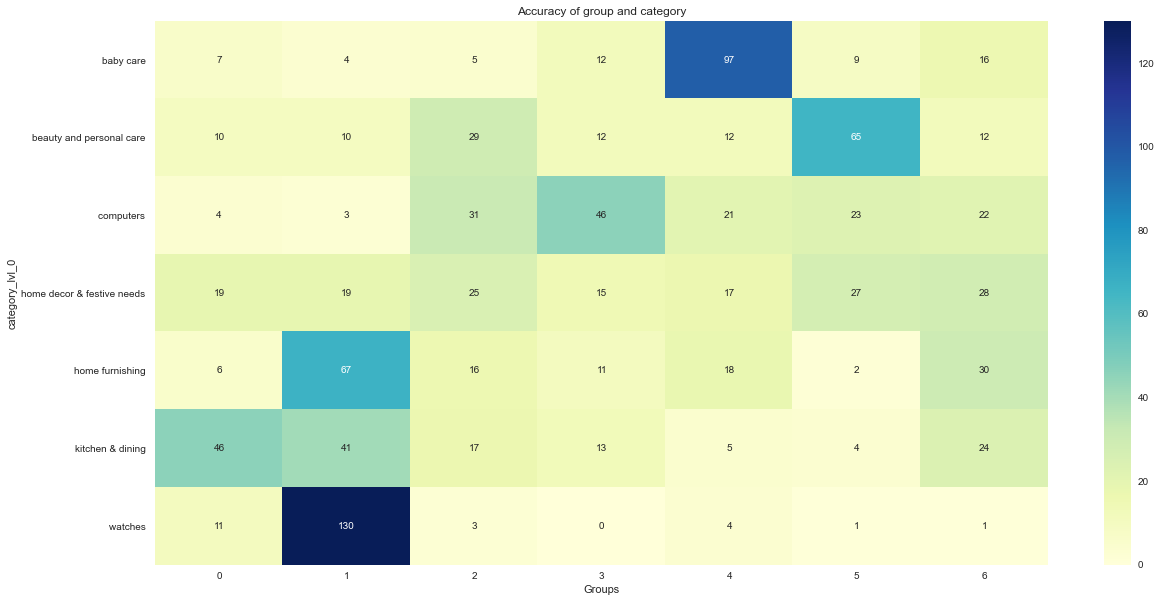

In [161]:
plt.figure(figsize=(20,10))
sns.heatmap(result, cmap="YlGnBu", annot=True,fmt='g')
plt.title('Accuracy of group and category')
plt.show()

# ARI LDA

In [162]:
from sklearn.metrics.cluster import adjusted_rand_score

le=LabelEncoder()
actual= le.fit_transform(toPredict['category_lvl_0'])
pred = toPredict['Groups'].values

print('ARI for LDA: '+str(adjusted_rand_score(actual,pred)))

ARI for LDA: 0.17911726989707108


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [163]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
# Load the library with the CountVectorizer method

# Initialise the count vectorizer with full stop words list
count_vectorizer = CountVectorizer(lowercase = True,
                                   max_df = 0.99,
                                   min_df = 0.01,
                                   ngram_range=(1,2)
                                  )

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['tokenize_text'])

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [165]:
tf_vectorizer = TfidfVectorizer(lowercase = True,
                                max_df = 0.99,
                                min_df = 0.01,
                                ngram_range=(1,2)
                               )

#Create TF/IDF Vectors
tf_data = tf_vectorizer.fit_transform(df['tokenize_text'])

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic modleing

In [166]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx}")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 7
number_words = 10

# Create and fit the LDA model for count vectorizer
lda_count = LDA(n_components=number_topics, n_jobs=-1, random_state = 42)
lda_count.fit(count_data)

# Create and fit the LDA model for TF/IDF vectorizer
lda_tf = LDA(n_components=number_topics, n_jobs=-1, random_state = 42)
lda_tf.fit(tf_data)


# Print the topics found by the LDA model
print("Topics found via LDA with Count Vectorizer:")
print_topics(lda_count, count_vectorizer, number_words)
print('\n')
print("Topics found via LDA with TF/IDF Vectorizer:")
print_topics(lda_tf, tf_vectorizer, number_words)

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics found via LDA with Count Vectorizer:

Topic #0
baby cotton girl baby girl fabric cover printed boy adapter baby boy

Topic #1
light led ceramic usb rockmantra creation led light blanket material size

Topic #2
watch analog analog watch boy watch boy great digital kadhai girl digital watch

Topic #3
usb home towel cotton art brass bath bottle hair box

Topic #4
watch analog analog watch dial strap polyester curtain gold water eyelet

Topic #5
combo skin box model material package laptop wall brand print

Topic #6
single ceramic abstract quilt prithish paper coffee comforter double bring


Topics found via LDA with TF/IDF Vectorizer:

Topic #0
baby girl baby girl cotton cover fabric printed baby boy dress cushion

Topic #1
wall handicraft sticker rockmantra ceramic creation making exclusive stay vinyl

Topic #2
watch analog analog watch kadhai watch boy boy great digital digital watch watch great

Topic #3
usb towel light led laptop battery brass bath cell cotton

Topic #4
analog 

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Visualize t-SNE with different levels of perplexity

# K Means for SVD

In [167]:
# Find optimal number of clusters
# Method obtained from: https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

wcss = []
for i in range(1, 100):
    kmeans = cluster.KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_trSVD)
    # Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


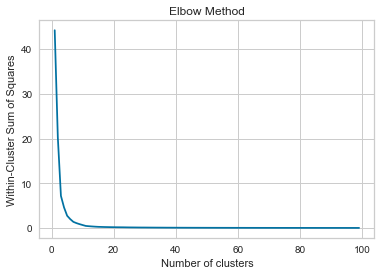

In [168]:
# Show Inertia Graph
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

In [169]:
silhouette_avg = []
davies_bouldin = []

for i in range(2, 100):
    clusterer = cluster.KMeans(n_clusters=i, random_state=42)
    cluster_labels = clusterer.fit_predict(X_trSVD)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg.append(silhouette_score(X_trSVD, cluster_labels))

    # clusters which are farther apart and less dispersed will result in a better score (closer to 0)
    davies_bouldin.append(davies_bouldin_score(X_trSVD, cluster_labels))

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [170]:
score = pd.DataFrame(columns=['Model', 'score'])
clusterer = cluster.KMeans(n_clusters=7, random_state=42)
cluster_labels = clusterer.fit_predict(X_pca)
score.at['0', 'Model'] = 'Kmeans'
score.at['0', 'score'] = silhouette_score(X_trSVD, cluster_labels)

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
score.at['1', 'Model'] = 'LDA'
score.at['1', 'score'] = coherence

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
score

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Model,score
0,Kmeans,0.642145
1,LDA,-7.861988


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


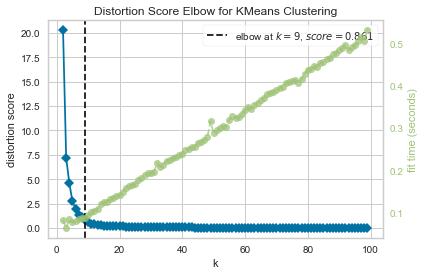

In [173]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 100))

visualizer.fit(X_trSVD)
visualizer.show() 
K_kmean=visualizer.elbow_value_
Score_kmean=visualizer.elbow_score_

# Silhouette

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


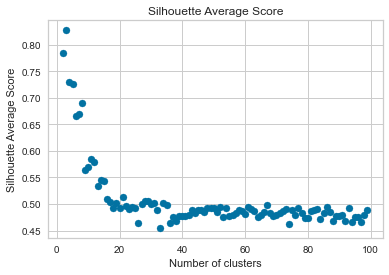

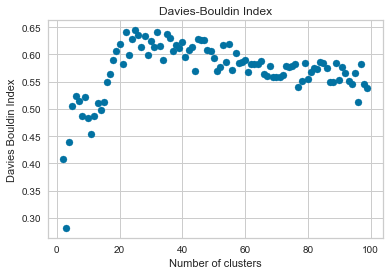

In [174]:
# Show Silhouette Graph
plt.scatter(range(2, 100), silhouette_avg)
plt.title('Silhouette Average Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Average Score')
plt.show()

# Show Davies Bouldin Graph
plt.scatter(range(2, 100), davies_bouldin)
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Index')
plt.show()

# t-SNE visualization with k means clustring

# Tsne with SVD

In [175]:
actual=final_tf_df['category_lvl_0'].unique()

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

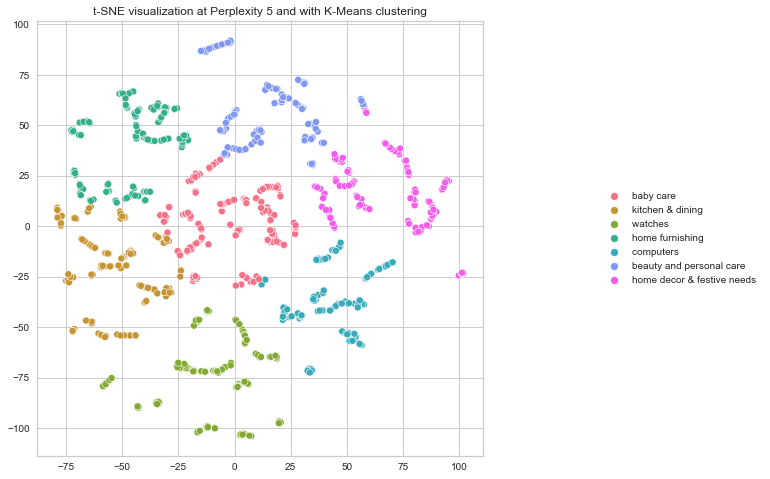

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


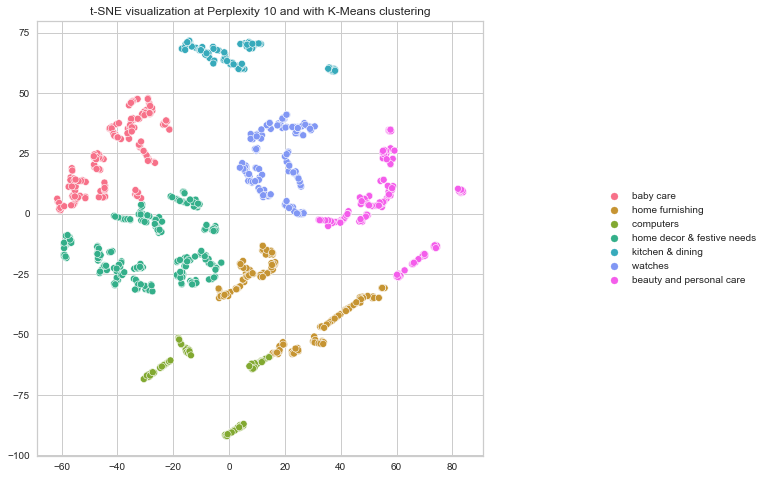

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


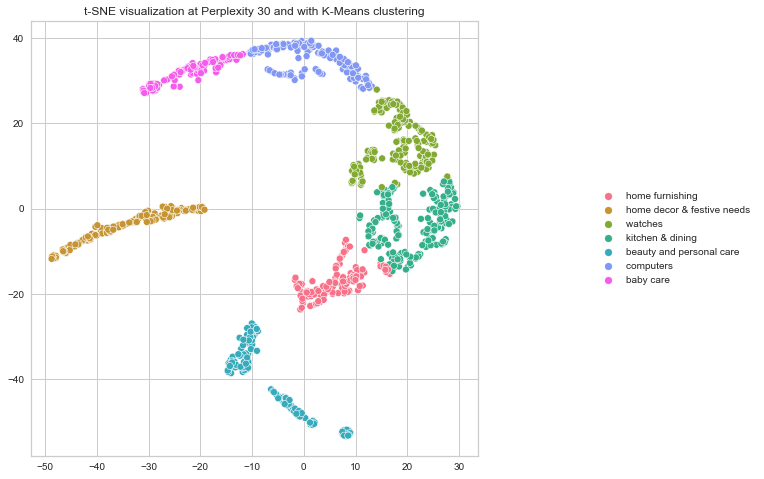

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


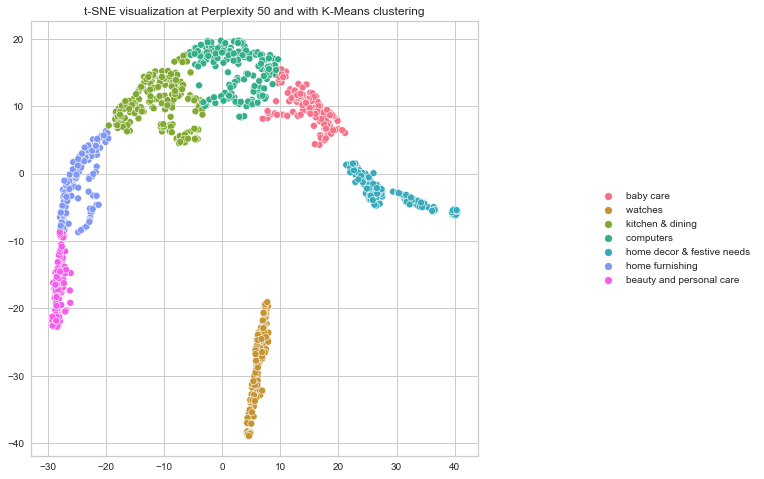

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


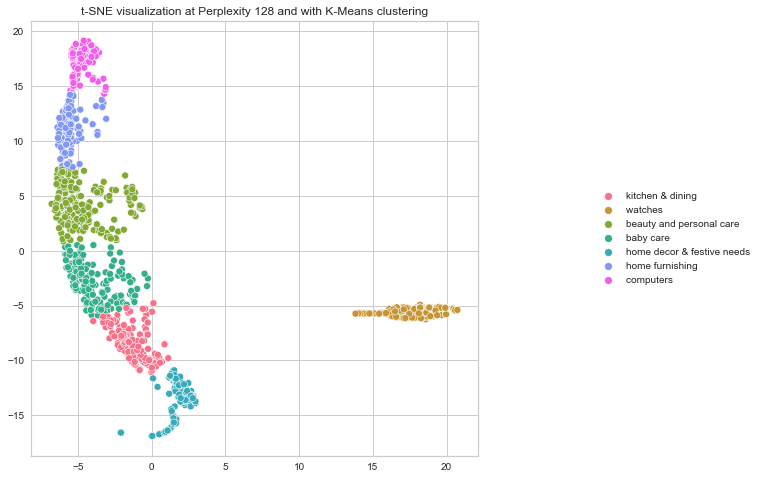

In [176]:
perplex_list = [5, 10, 30, 50, 128]
for i in perplex_list:
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=i, random_state=42)
    T = tsne.fit_transform(X_trSVD)
    if i==50:
        tempTnse=pd.DataFrame(T,columns=['Tnse1','Tnse2'])
    # Create cluster with 7 clusters
    n_clusters = 7
    clust = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    clust.fit(T)
    # Visualize
    labels=pd.DataFrame(clust.labels_,columns=['Labels'])
    labels['Labels']=labels['Labels'].astype(str)
    labels['Labels'] = labels['Labels'].str.replace('0',actual[0])
    labels['Labels'] = labels['Labels'].str.replace('1',actual[1])
    labels['Labels'] = labels['Labels'].str.replace('2',actual[2])
    labels['Labels'] = labels['Labels'].str.replace('3',actual[3])
    labels['Labels'] = labels['Labels'].str.replace('4',actual[4])
    labels['Labels'] = labels['Labels'].str.replace('5',actual[5])
    labels['Labels'] = labels['Labels'].str.replace('6',actual[6])

    plt.figure(figsize=(8, 8))
    plt.title('t-SNE visualization at Perplexity '+str(i)+' and with K-Means clustering')
    g=sns.scatterplot(T[:, 0], T[:, 1], hue=labels.values.reshape(1, -1)[0], legend = True)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

In [177]:
result = pd.concat([df, tempTnse], axis=1)
result

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,image,category_lvl_0,category_lvl_1,category_lvl_2,descriptions,tokenize_text,Tnse1,Tnse2
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,curtains & accessories,curtains,eleg polyest multicol abstract eyelet door cur...,elegance polyester abstract eyelet door curtai...,17.008854,8.604925
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,baby bath & skin,baby bath towels,sathiy cotton bath towel spec of sathiy cotton...,sathiyas cotton bath towel sathiyas cotton bat...,18.155876,6.034329
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,baby bath & skin,baby bath towels,eurosp cotton terr fac towel set key feat of e...,eurospa cotton terry face towel key eurospa co...,18.769527,6.709494
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,bed linen,bedsheets,santosh roy fash cotton print king siz doubl b...,santosh royal fashion cotton printed king size...,17.108631,5.646379
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,bed linen,bedsheets,jaip print cotton flor king siz doubl bedsheet...,jaipur print cotton floral king sized double b...,17.911039,7.606721
...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,baby & kids gifts,stickers,or empow extr larg self adh stick or empow ext...,oren empower extra large self adhesive sticker...,-7.970075,13.875536
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,baby & kids gifts,stickers,wallmantr larg vinyl stick stick wallmantr lar...,wallmantra large vinyl sticker sticker wallman...,18.559217,8.651677
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,baby & kids gifts,stickers,uberlyf extr larg pig polyvinyl film (imported...,uberlyfe extra large pigmented polyvinyl film ...,-27.773247,-7.747322
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,baby & kids gifts,stickers,wallmantr med vinyl stick stick buy wallmantr ...,wallmantra medium vinyl sticker sticker wallma...,-21.705462,4.105538


# Tsne with PCA

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

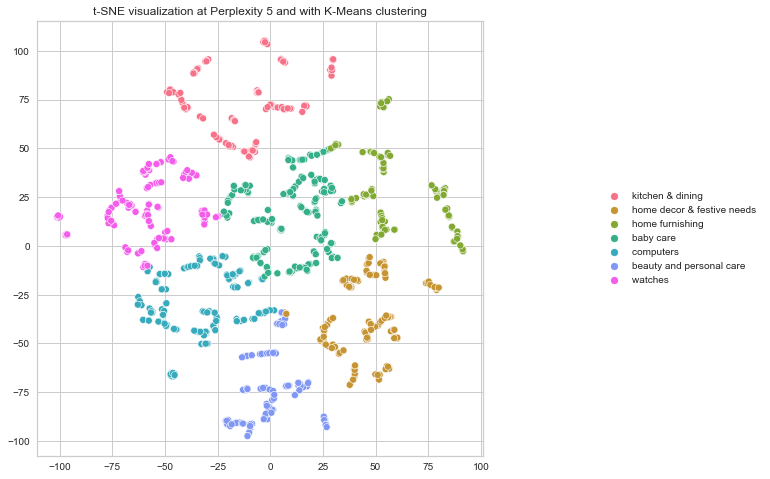

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


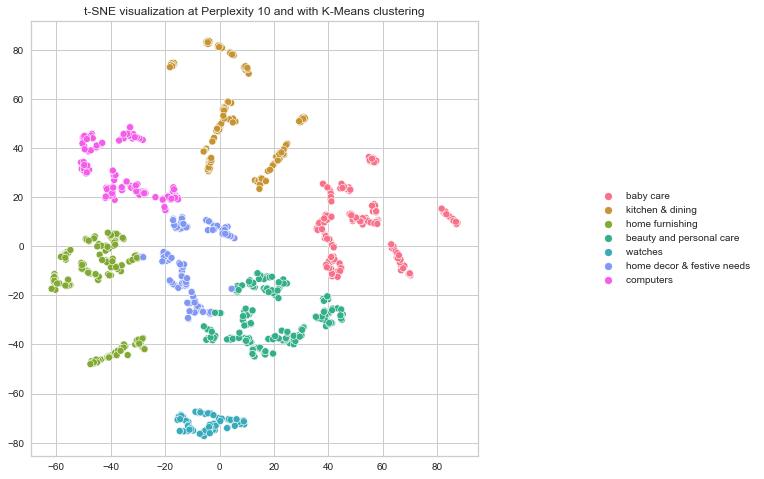

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


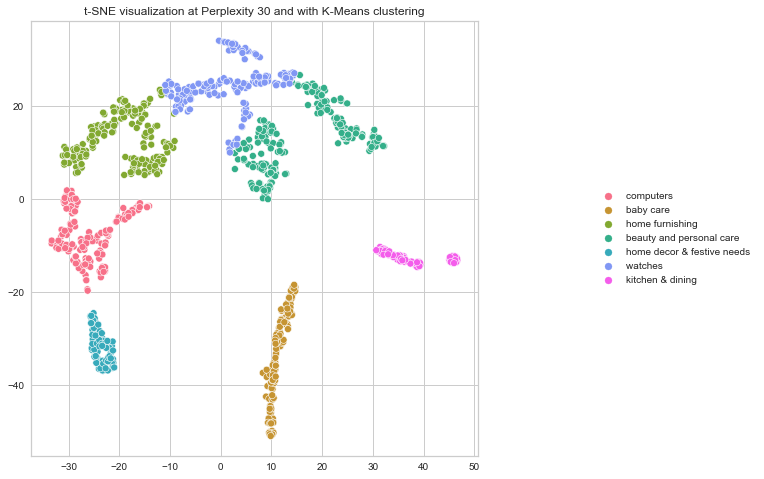

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


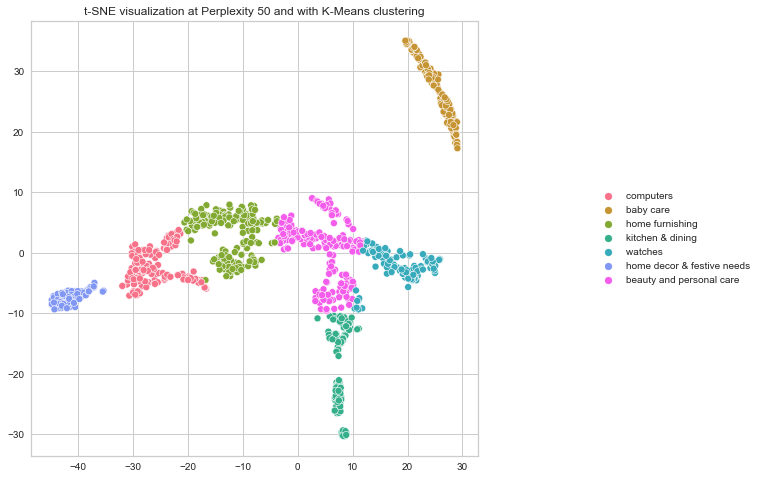

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


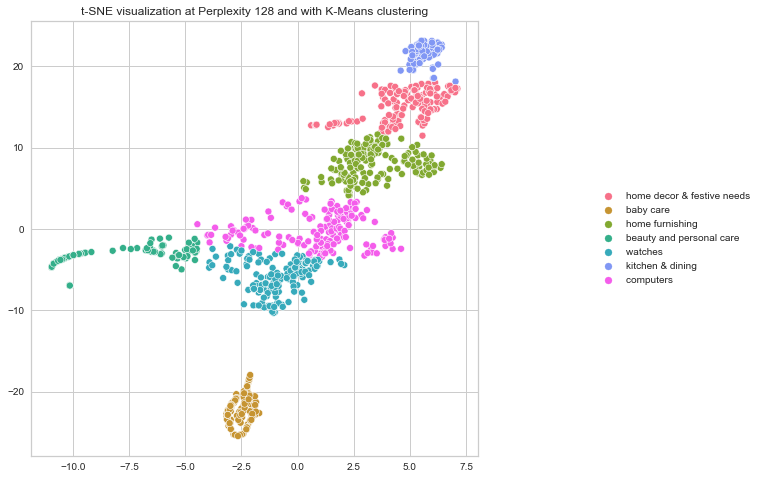

In [178]:
perplex_list = [5, 10, 30, 50, 128]
for i in perplex_list:
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=i, random_state=42)
    T = tsne.fit_transform(X_pca)
#     Create cluster with 7 clusters
    n_clusters = 7
    clust = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    clust.fit(T)
    # Visualize
    labels=pd.DataFrame(clust.labels_,columns=['Labels'])
    labels['Labels']=labels['Labels'].astype(str)
    labels['Labels'] = labels['Labels'].str.replace('0',actual[0])
    labels['Labels'] = labels['Labels'].str.replace('1',actual[1])
    labels['Labels'] = labels['Labels'].str.replace('2',actual[2])
    labels['Labels'] = labels['Labels'].str.replace('3',actual[3])
    labels['Labels'] = labels['Labels'].str.replace('4',actual[4])
    labels['Labels'] = labels['Labels'].str.replace('5',actual[5])
    labels['Labels'] = labels['Labels'].str.replace('6',actual[6])

    plt.figure(figsize=(8, 8))
    plt.title('t-SNE visualization at Perplexity '+str(i)+' and with K-Means clustering')
    g=sns.scatterplot(T[:, 0], T[:, 1], hue=labels.values.reshape(1, -1)[0], legend = True)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

# Tsne with Kpca

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

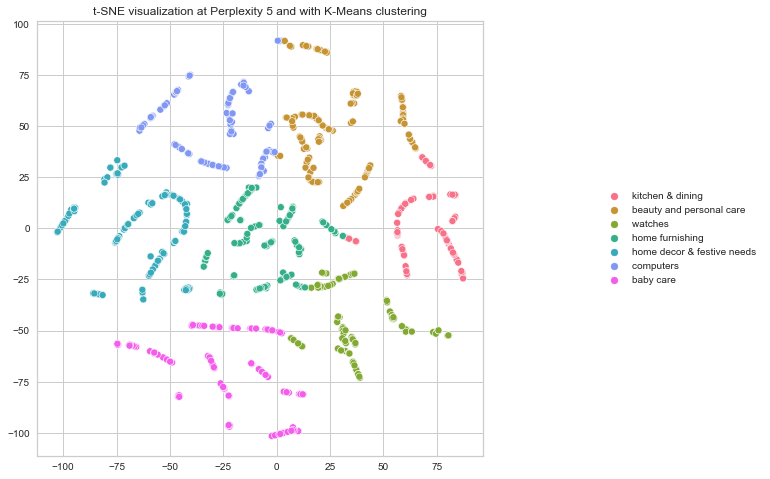

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


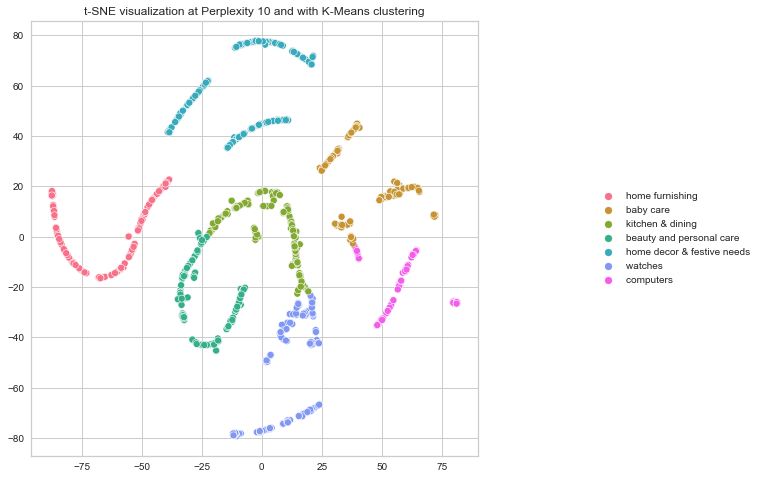

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


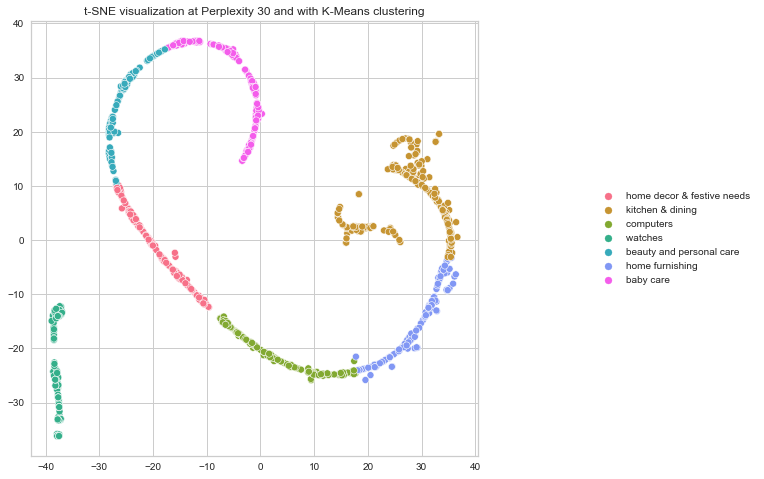

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


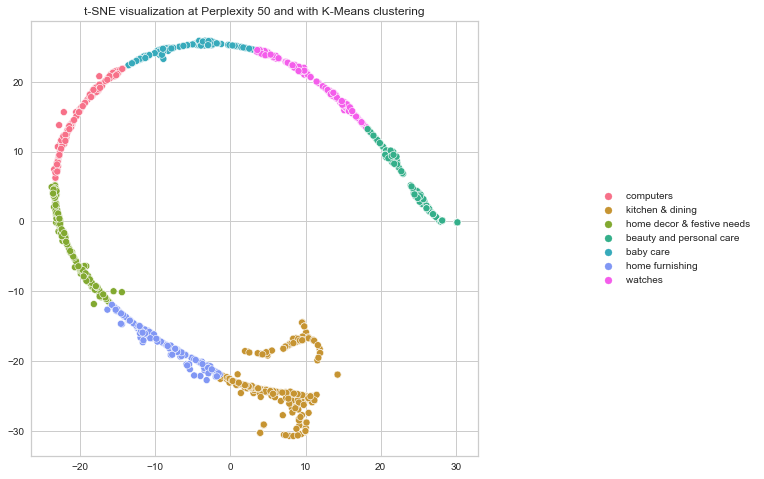

C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


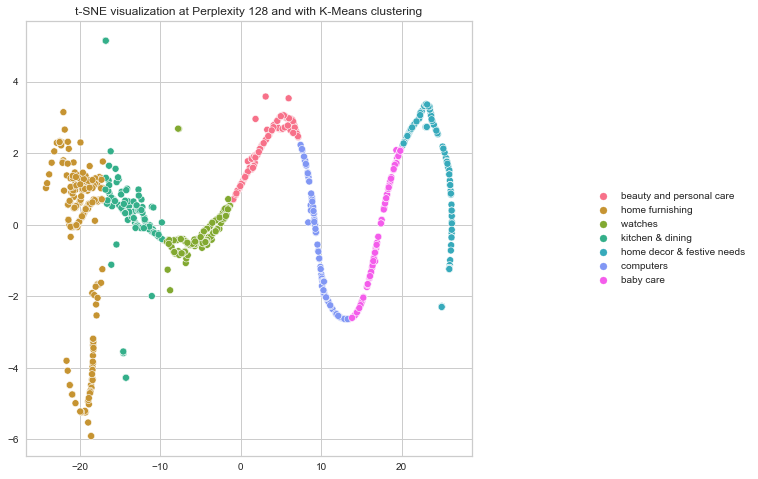

In [179]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10)
X_kpca = kpca.fit_transform(X_tf)

perplex_list = [5, 10, 30, 50, 128]
for i in perplex_list:
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=i, random_state=42)
    T = tsne.fit_transform(X_kpca)
    
    # Create cluster with 7 clusters
    n_clusters = 7
    clust = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    clust.fit(T)
    # Visualize
    labels=pd.DataFrame(clust.labels_,columns=['Labels'])
    labels['Labels']=labels['Labels'].astype(str)
    labels['Labels'] = labels['Labels'].str.replace('0',actual[0])
    labels['Labels'] = labels['Labels'].str.replace('1',actual[1])
    labels['Labels'] = labels['Labels'].str.replace('2',actual[2])
    labels['Labels'] = labels['Labels'].str.replace('3',actual[3])
    labels['Labels'] = labels['Labels'].str.replace('4',actual[4])
    labels['Labels'] = labels['Labels'].str.replace('5',actual[5])
    labels['Labels'] = labels['Labels'].str.replace('6',actual[6])

    plt.figure(figsize=(8, 8))
    plt.title('t-SNE visualization at Perplexity '+str(i)+' and with K-Means clustering')
    g=sns.scatterplot(T[:, 0], T[:, 1], hue=labels.values.reshape(1, -1)[0], legend = True)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

In [180]:
result = pd.DataFrame(final_tf_df['category_lvl_0'].values,columns=['category'])

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [181]:
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
T = tsne.fit_transform(X_trSVD)

n_clusters = 7
clust = cluster.KMeans(n_clusters=n_clusters, random_state=42)
clust.fit(T)
# Visualize
labels=pd.DataFrame(clust.labels_,columns=['Groups'])
toPredict=pd.concat([result, labels], axis=1)
result=pd.concat([result, labels], axis=1)


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\PCANACONDA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [182]:
result=result.groupby(['Groups','category']).size().reset_index(name='counts')

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [183]:
result

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Groups,category,counts
0,0,baby care,13
1,0,beauty and personal care,64
2,0,computers,18
3,0,home decor & festive needs,31
4,0,home furnishing,1
5,0,kitchen & dining,14
6,1,baby care,19
7,1,beauty and personal care,6
8,1,computers,13
9,1,home decor & festive needs,11


In [184]:
result = pd.pivot_table(result, values='counts',index=['category'], columns=['Groups'], aggfunc=np.sum)
result.fillna(0, inplace=True)

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [185]:
result

C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Groups,0,1,2,3,4,5,6
category,,,,,,,
baby care,13.0,19.0,0.0,77.0,13.0,4.0,24.0
beauty and personal care,64.0,6.0,0.0,0.0,50.0,13.0,17.0
computers,18.0,13.0,0.0,0.0,47.0,47.0,25.0
home decor & festive needs,31.0,11.0,3.0,1.0,38.0,32.0,34.0
home furnishing,1.0,62.0,0.0,1.0,22.0,0.0,64.0
kitchen & dining,14.0,11.0,0.0,73.0,19.0,18.0,15.0
watches,0.0,0.0,150.0,0.0,0.0,0.0,0.0


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


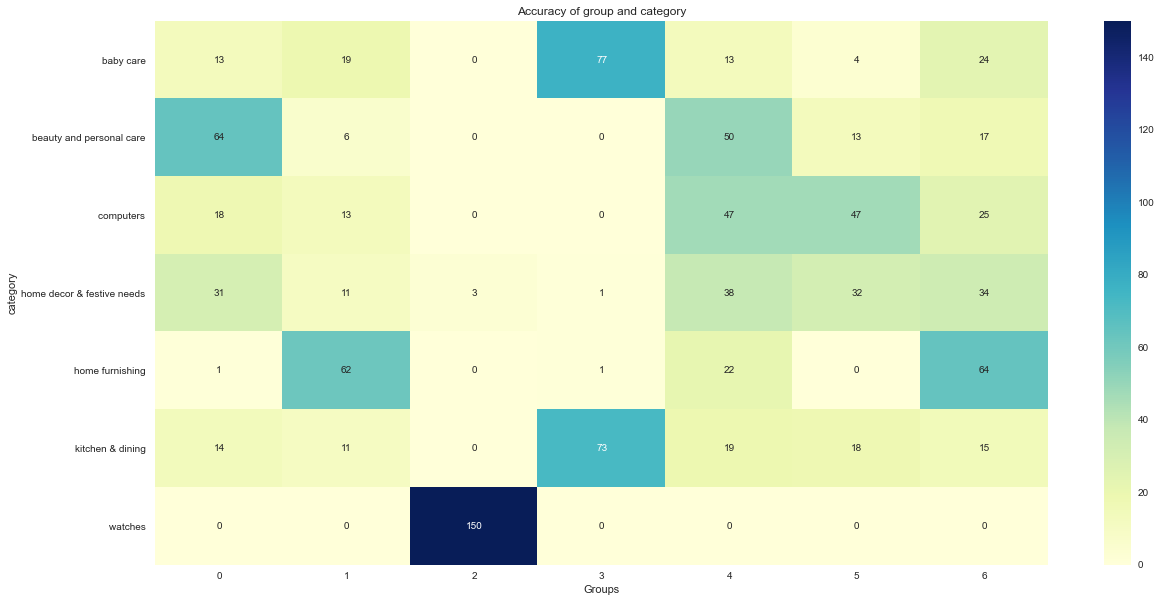

In [186]:
plt.figure(figsize=(20,10))
sns.heatmap(result, cmap="YlGnBu", annot=True,fmt='g')
plt.title('Accuracy of group and category')
plt.show()

# ARI Kmeans

In [187]:
from sklearn.metrics.cluster import adjusted_rand_score

le=LabelEncoder()
actual= le.fit_transform(toPredict['category'])
pred = toPredict['Groups'].values

print('ARI for kmeans: '+str(adjusted_rand_score(actual,pred)))

ARI for kmeans: 0.2806559406083021


C:\PCANACONDA\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
